# Evaluation BASELINE OI: 

This notebook presents the evaluation of the SSH reconstructions based on the BASELINE OI and performed for the **"2021a_SSH_mapping_OSE" ocean data challenge**. 

In [1]:
import os
import sys
sys.path.append('..')
import logging
import pandas as pd
import numpy
sys.path.remove('/Users/sammymetref/Documents/DataChallenges/DC_IW_crossoverCal/2022a_mapping_HFdynamic')

In [2]:
from src.mod_inout import *
from src.mod_interp import *
from src.mod_stats import *
from src.mod_spectral import *
from src.mod_plot import *

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

### Study Area & Ouput Parameters

In [4]:
# study area
lon_min = 1.                                           # domain min longitude
lon_max = 20.                                           # domain max longitude
lat_min = 30.                                            # domain min latitude
lat_max = 45.                                            # domain max latitude
time_min = numpy.datetime64('2021-01-15')                # domain min time
time_max = numpy.datetime64('2021-03-15')                # domain max time

is_circle = False 

# Outputs
bin_lat_step = 0.05
bin_lon_step = 0.05

bin_time_step = '1D'
output_directory = '../results'
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
output_filename = f'{output_directory}/stat_OSE_BASELINE_{time_min}_{time_max}_{lon_min}_{lon_max}_{lat_min}_{lat_max}.nc'
output_filename_timeseries = f'{output_directory}/stat_timeseries_OSE_BASELINE_{time_min}_{time_max}_{lon_min}_{lon_max}_{lat_min}_{lat_max}.nc'

# Spectral parameter
# C2 parameter
delta_t = 0.9434  # s
velocity = 6.77   # km/s
delta_x = velocity * delta_t
lenght_scale = 100 # sehment length scale in km
output_filename_spectrum = f'{output_directory}/psd_OSE_BASELINE_v2_{time_min}_{time_max}_{lon_min}_{lon_max}_{lat_min}_{lat_max}.nc'

### Read L3 datasets

In [5]:
# Get pseuso-observation
!wget https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/fileServer/meomopendap/extract/ocean-data-challenges/dc_MapMed_OSE/dc_eval.tar.gz
!tar -xvf dc_eval.tar.gz --directory ../inputs
!rm -f dc_eval.tar.gz    

--2022-08-09 16:36:04--  https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/fileServer/meomopendap/extract/ocean-data-challenges/dc_MapMed_OSE/dc_eval.tar.gz
Résolution de ige-meom-opendap.univ-grenoble-alpes.fr (ige-meom-opendap.univ-grenoble-alpes.fr)… 129.88.191.39
Connexion à ige-meom-opendap.univ-grenoble-alpes.fr (ige-meom-opendap.univ-grenoble-alpes.fr)|129.88.191.39|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 200
Taille : 324449 (317K) [application/octet-stream]
Sauvegarde en : « dc_eval.tar.gz »

dc_eval.tar.gz      100%[===================>] 316,84K   908KB/s    ds 0,3s    

2022-08-09 16:36:05 (908 KB/s) — « dc_eval.tar.gz » sauvegardé [324449/324449]

x dc_eval/
x dc_eval/dt_med_c2n_phy_l3_20210101-20210331_0-20_30-45.nc


In [6]:
# independent along-track
alontrack_independent_dataset = '../inputs/dc_eval/dt_med_c2n_phy_l3_20210101-20210331_0-20_30-45.nc'

# Read along-track
ds_alongtrack = read_l3_dataset(alontrack_independent_dataset,
                                           lon_min=lon_min, 
                                           lon_max=lon_max, 
                                           lat_min=lat_min, 
                                           lat_max=lat_max, 
                                           time_min=time_min, 
                                           time_max=time_max)
ds_alongtrack

<xarray.Dataset>
Dimensions:         (time: 10577)
Coordinates:
  * time            (time) datetime64[ns] 2021-01-16T02:03:52.580988928 ... 2...
    longitude       (time) float64 11.09 11.08 11.06 11.05 ... 18.5 18.49 18.49
    latitude        (time) float64 33.65 33.7 33.88 33.93 ... 42.25 42.31 42.36
Data variables:
    sla_unfiltered  (time) float32 0.120000005 0.096 ... -0.029000001
    mdt             (time) float32 0.048 0.048 ... -0.105000004 -0.101
    lwe             (time) float32 0.011000001 0.012 0.014 ... -0.016 -0.016

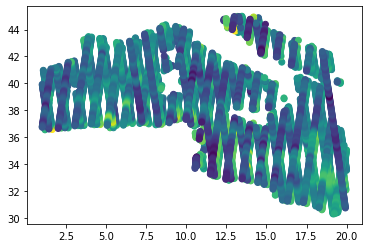

In [7]:
plt.scatter(ds_alongtrack.longitude,ds_alongtrack.latitude,c=ds_alongtrack.sla_unfiltered)

### Read L4 dataset and interpolate onto along-track positions

In [8]:
# series of maps to evaluate
# gridded_dataset = '../results/OSE_ssh_mapping_BASELINE.nc'
# Alternatively, read data from AVISO server
gridded_dataset = '../results/dt_med_mapping_baselineOI.nc'
# Interpolate maps onto alongtrack dataset
time_alongtrack, lat_alongtrack, lon_alongtrack, ssh_alongtrack, ssh_map_interp = interp_on_alongtrack(gridded_dataset, 
                                                                                                       ds_alongtrack,
                                                                                                       lon_min=lon_min, 
                                                                                                       lon_max=lon_max, 
                                                                                                       lat_min=lat_min, 
                                                                                                       lat_max=lat_max, 
                                                                                                       time_min=time_min, 
                                                                                                       time_max=time_max,
                                                                                                       is_circle=is_circle)

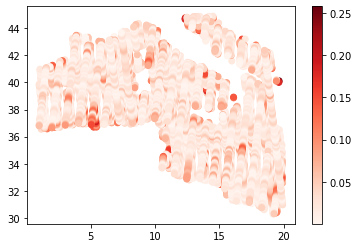

In [9]:
plt.scatter(lon_alongtrack,lat_alongtrack,c=numpy.abs(ssh_alongtrack - ssh_map_interp),cmap='Reds')
plt.colorbar()

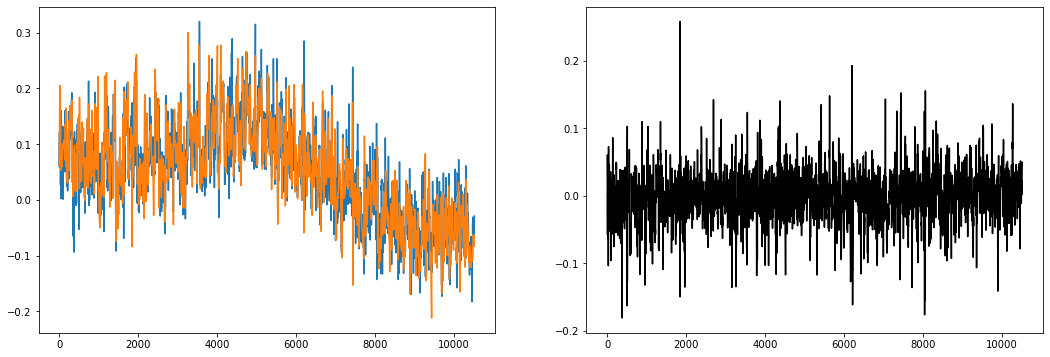

In [10]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.plot(ssh_alongtrack)
plt.plot(ssh_map_interp)
plt.subplot(122)
plt.plot(ssh_alongtrack-ssh_map_interp,'k')

### Compute statistical score

In [11]:
leaderboard_nrmse, leaderboard_nrmse_std = compute_stats(time_alongtrack, 
                                                         lat_alongtrack, 
                                                         lon_alongtrack, 
                                                         ssh_alongtrack, 
                                                         ssh_map_interp, 
                                                         bin_lon_step,
                                                         bin_lat_step, 
                                                         bin_time_step,
                                                         output_filename,
                                                         output_filename_timeseries)

INFO:root:  Results saved in: ../results/stat_OSE_BASELINE_2021-01-15_2021-03-15_1.0_20.0_30.0_45.0.nc
INFO:root: 
INFO:root:  Results saved in: ../results/stat_timeseries_OSE_BASELINE_2021-01-15_2021-03-15_1.0_20.0_30.0_45.0.nc
INFO:root: 
INFO:root:  MEAN RMSE Score = 0.5533243479839672
INFO:root: 
INFO:root:  STD RMSE Score = 0.1785446122277098


In [12]:
plot_spatial_statistics(output_filename)

:Image   [lon,lat]   (rmse)

In [13]:
plot_temporal_statistics(output_filename_timeseries)

:Layout
   .Curve.I  :Curve   [time]   (rms)
   .Curve.II :Curve   [time]   (count)

### Compute spectral scores

In [14]:
compute_spectral_scores(time_alongtrack, 
                        lat_alongtrack, 
                        lon_alongtrack, 
                        ssh_alongtrack, 
                        ssh_map_interp, 
                        lenght_scale,
                        delta_x,
                        delta_t,
                        output_filename_spectrum)

INFO:root:  Results saved in: ../results/psd_OSE_BASELINE_v2_2021-01-15_2021-03-15_1.0_20.0_30.0_45.0.nc


NameError: name 'resolved_scale' is not defined

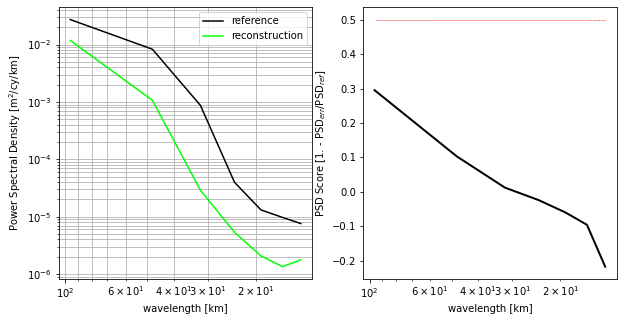

In [15]:
leaderboard_psds_score = plot_psd_score(output_filename_spectrum)

### Show leaderboard metrics

In [ ]:
# Print leaderboard
data = [['BASELINE', 
         leaderboard_nrmse, 
         leaderboard_nrmse_std, 
         int(leaderboard_psds_score),
        'Covariances BASELINE OI',
        'example_eval_baseline.ipynb']]
Leaderboard = pd.DataFrame(data, 
                           columns=['Method', 
                                    "µ(RMSE) ", 
                                    "σ(RMSE)", 
                                    'λx (km)',  
                                    'Notes',
                                    'Reference'])
print("Summary of the leaderboard metrics:")
Leaderboard
print(Leaderboard.to_markdown())